In [1]:
import pandas as pd
import requests, zipfile, io
!pip install pyxlsb
import pyxlsb
from IPython.core.display import HTML
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

# Set up some default parameters for graphing
import matplotlib.pyplot as plt
from matplotlib import cycler
colour = "#00C2AB" # The default colour for the barcharts
colors = cycler('color', ['#4FBBA9', '#E56D13', '#D43A69','#25539f', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.rc('legend', fancybox = True, framealpha=1, shadow=True, borderpad=1)

In [2]:
# We will load in the sheets in the unzipped XLSX file that contain various kinds of direct emissions, from individual facilities and sectors/activities
ghg_fac = pd.read_excel("ghgp_data_2020.xlsx",
  skiprows = 1, # skip the first two rows, which are irrelevant
  header = 2, # the third row represents the header
  converters={'Primary NAICS Code':str}, # read the NAICS codes as strings
  sheet_name = ["Direct Emitters", "Onshore Oil & Gas Prod.", "Gathering & Boosting", 
    "Transmission Pipelines", "LDC - Direct Emissions", "SF6 from Elec. Equip.", "Suppliers"]) 

# We will also load in a file that tells us about the type of industry each facility is classified as
naics = pd.read_excel("https://www.census.gov/naics/2017NAICS/6-digit_2017_Codes.xlsx",
  header = 0, # the row that represents the header
  converters={'2017 NAICS Code':str,'2017 NAICS Title':str}
)
naics=naics[["2017 NAICS Code", "2017 NAICS Title"]]

In [3]:
ghg_fac["Suppliers"]["Emissions (tCO2e)"] = pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Coal-based liquid fuel production"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Petroleum Products Produced"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Petroleum Products Imported"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Petroleum Products Exported"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Natural Gas Supply"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Natural Gas Liquids Supply"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with CO2 Supply "], errors='coerce').fillna(0)

emissions_field_names = {
    "Direct Emitters": "Total reported direct emissions",
    "Onshore Oil & Gas Prod.": "Total reported emissions from Onshore Oil & Gas Production ",
    "Gathering & Boosting": "Total reported emissions from Gathering & Boosting",
    "Transmission Pipelines": "Total reported direct emissions from Transmission Pipelines",
    "LDC - Direct Emissions": "Total reported direct emissions from Local Distribution Companies",
    "SF6 from Elec. Equip.": "Total reported direct emissions from Electrical Equipment Use"
}

fac_directemitters_data = pd.DataFrame([], columns=["Facility", "Name", "Primary NAICS Code", "Emissions (tCO2e)"]) 
fac_suppliers_data = pd.DataFrame(ghg_fac["Suppliers"]) 

for key in emissions_field_names.keys():
  dump = ghg_fac[key]
  dump = dump[["Facility Id", "Facility Name", "Primary NAICS Code", emissions_field_names[key]]]
  dump = dump.rename(columns={"Facility Id": "Facility", "Facility Name": "Name", "Primary NAICS Code": "2017 NAICS Code", emissions_field_names[key]:"Emissions (tCO2e)"})
  dump["Emissions (tCO2e)"] = pd.to_numeric(dump["Emissions (tCO2e)"])
  fac_directemitters_data= fac_directemitters_data.append(dump)

fac_directemitters_data = fac_directemitters_data.groupby(by=["Facility", "Name", "2017 NAICS Code"]).sum().reset_index() #For presentation purposes, we'll add in the facility name
fac_suppliers_data=fac_suppliers_data.rename(columns={"Facility Id": "Facility", "Facility Name": "Name", "Primary NAICS Code": "2017 NAICS Code"})
fac_suppliers_data = fac_suppliers_data[["Facility", "Name", "2017 NAICS Code", "Emissions (tCO2e)"]]
fac_directemitters_data['2017 NAICS Code']=fac_directemitters_data['2017 NAICS Code'].astype(str)

# Look up industry information
fac_directemitters_data = fac_directemitters_data.merge(naics, on="2017 NAICS Code")
fac_suppliers_data = fac_suppliers_data.merge(naics, on="2017 NAICS Code")


In [4]:
url = "https://www.epa.gov/system/files/other-files/2021-10/ghgp_data_parent_company_10_2021.xlsb"
parents = pd.read_excel(url, engine='pyxlsb', sheet_name="2020", nrows=9144) # 9144 non-header rows in this file as of Nov 2021.
parents["PARENT COMPANY NAME"] = parents["PARENT COMPANY NAME"].str.upper() # Standardize company names to uppercase - sometimes EPA allows company names to be reported in upper and lower case, which intereferes with our ability to aggregate them
parents

,GHGRP FACILITY ID,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE
0,1000001,1.100005e+11,2020,PSE Ferndale Generating Station,5105 LAKE TERRELL ROAD,FERNDALE,WA,98248,WHATCOM COUNTY,PUGET HOLDINGS LLC,PO Box 97034,Bellevue,WA,98009,100.0,221112
1,1000002,1.100412e+11,2020,Ardagh Glass Inc. (Dunkirk),524 E. CENTER STREET,DUNKIRK,IN,47336,JAY COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213
2,1000003,1.100015e+11,2020,Ardagh Glass Inc. (Henderson),620 Facet Road,Henderson,NC,27537,VANCE COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213
3,1000005,1.100005e+11,2020,Ardagh Glass Inc. (Madera),24441 AVENUE 12 & ROAD 24 1/2,MADERA,CA,93637,MADERA COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213
4,1000007,1.100070e+11,2020,AMERICAN GYPSUM - BERNALILLO (WALLBOARD) PLANT,1000 N HILL RD,BERNALILLO,NM,87004,SANDOVAL COUNTY,EAGLE MATERIALS INC,5960 Berkshire Lane Suite 800,Dallas,TX,75225,100.0,327420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9139,1014033,NaN,2020,AW PRODUCT SALES AND MARKETING INC,"204 E. 2nd Avenue, Unit #343",San Mateo,CA,94401,NaN,AW DISTRIBUTING INC,"204 E. 2nd Avenue, Unit #343",San Mateo,CA,94401,100.0,522293
9140,1014041,NaN,2020,"Bluon, Inc.",18 Bunsen,Irvine,CA,92618,NaN,BLUON INC,18 Bunsen,Irvine,CA,92618,100.0,424690
9141,1014043,NaN,2020,RAMJ Enterprises Inc,4912 W KNOX ST STE 100,Tampa,FL,33634,NaN,RAMJ ENTERPRISES INC,4912 W KNOX ST,Tampa,FL,33634,100.0,425120
9142,1014044,1.100626e+11,2020,Wilhelmsen Ships Service Inc,9400 New Century Dr,Pasadena,TX,77507,HARRIS COUNTY,WILHELMSEN SHIPS SERVICE,9400 New Century Dr.,Pasadena,TX,77507,100.0,484220


In [5]:
join_emitters = fac_directemitters_data.set_index("Facility").join(parents.set_index('GHGRP FACILITY ID'))
join_suppliers = fac_suppliers_data.set_index("Facility").join(parents.set_index('GHGRP FACILITY ID'))

(array([987.,  77.,  33.,  17.,  13.,   6.,   1.,   3.,   2.,   2.]),
 array([       0.        ,  8468430.17350562, 16936860.34701124,
        25405290.52051686, 33873720.69402248, 42342150.8675281 ,
        50810581.04103373, 59279011.21453935, 67747441.38804497,
        76215871.56155059, 84684301.7350562 ]),
 <BarContainer object of 10 artists>)

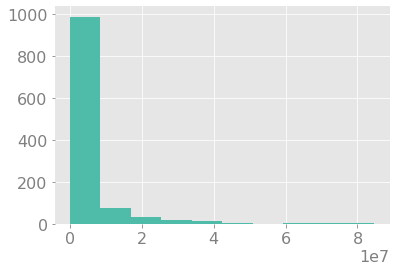

In [6]:
plt.hist(join_suppliers['Emissions (tCO2e)'])

In [7]:
nas_s = join_suppliers.loc[join_suppliers["Emissions (tCO2e)"]  == 0]

In [8]:
nas_s

,Name,2017 NAICS Code,Emissions (tCO2e),2017 NAICS Title,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE
1000035,THE ANDERSONS MARATHON HOLDINGS LLC,325193,0.0,Ethyl Alcohol Manufacturing,1.100376e+11,2020,THE ANDERSONS MARATHON HOLDINGS LLC,5728 E SEBRING WARNER RD,GREENVILLE,OH,45331,DARKE COUNTY,THE ANDERSONS INC,PO Box 119,Maumee,OH,43537,50.0,325193
1000035,THE ANDERSONS MARATHON HOLDINGS LLC,325193,0.0,Ethyl Alcohol Manufacturing,1.100376e+11,2020,THE ANDERSONS MARATHON HOLDINGS LLC,5728 E SEBRING WARNER RD,GREENVILLE,OH,45331,DARKE COUNTY,MARATHON PETROLEUM CORP,539 South Main Street,Findlay,OH,45840,25.0,325193
1000035,THE ANDERSONS MARATHON HOLDINGS LLC,325193,0.0,Ethyl Alcohol Manufacturing,1.100376e+11,2020,THE ANDERSONS MARATHON HOLDINGS LLC,5728 E SEBRING WARNER RD,GREENVILLE,OH,45331,DARKE COUNTY,MARATHON PETROLEUM CORP,539 South Main Street,Findlay,OH,45840,25.0,325193
1000039,GE's Grid Solutions,335313,0.0,Switchgear and Switchboard Apparatus Manufactu...,1.100329e+11,2020,GE's Grid Solutions,One Power Lane,Charleroi,PA,15022,WASHINGTON COUNTY,GENERAL ELECTRIC CO,41 Farnsworth Street,Boston,MA,2210,100.0,335313
1000158,Ascend (Decatur Plant),325199,0.0,All Other Basic Organic Chemical Manufacturing,1.100072e+11,2020,Ascend (Decatur Plant),1050 CHEMSTRAND AVENUE,DECATUR,AL,35601,Morgan,ASCEND PERFORMANCE MATERIALS HOLDINGS INC,"1010 Travis Street, Suite 900",Houston,TX,77002-3014,100.0,325199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014033,AW PRODUCT SALES AND MARKETING INC,522293,0.0,International Trade Financing,NaN,2020,AW PRODUCT SALES AND MARKETING INC,"204 E. 2nd Avenue, Unit #343",San Mateo,CA,94401,NaN,AW DISTRIBUTING INC,"204 E. 2nd Avenue, Unit #343",San Mateo,CA,94401,100.0,522293
1014041,"Bluon, Inc.",424690,0.0,Other Chemical and Allied Products Merchant Wh...,NaN,2020,"Bluon, Inc.",18 Bunsen,Irvine,CA,92618,NaN,BLUON INC,18 Bunsen,Irvine,CA,92618,100.0,424690
1014043,RAMJ Enterprises Inc,425120,0.0,Wholesale Trade Agents and Brokers,NaN,2020,RAMJ Enterprises Inc,4912 W KNOX ST STE 100,Tampa,FL,33634,NaN,RAMJ ENTERPRISES INC,4912 W KNOX ST,Tampa,FL,33634,100.0,425120
1014044,Wilhelmsen Ships Service Inc,484220,0.0,Specialized Freight (except Used Goods) Trucki...,1.100626e+11,2020,Wilhelmsen Ships Service Inc,9400 New Century Dr,Pasadena,TX,77507,HARRIS COUNTY,WILHELMSEN SHIPS SERVICE,9400 New Century Dr.,Pasadena,TX,77507,100.0,484220


In [13]:
nas_s['PARENT COMPANY NAME']

1000035                             THE ANDERSONS INC
1000035                       MARATHON PETROLEUM CORP
1000035                       MARATHON PETROLEUM CORP
1000039                           GENERAL ELECTRIC CO
1000158     ASCEND PERFORMANCE MATERIALS HOLDINGS INC
                              ...                    
1014033                           AW DISTRIBUTING INC
1014041                                     BLUON INC
1014043                          RAMJ ENTERPRISES INC
1014044                      WILHELMSEN SHIPS SERVICE
1014063    TRANSOCEAN OFFSHORE DEEPWATER DRILLING INC
Name: PARENT COMPANY NAME, Length: 364, dtype: object

In [14]:
join_emitters["PARENT EMISSIONS AMT"] = join_emitters['Emissions (tCO2e)'] * join_emitters["PARENT CO. PERCENT OWNERSHIP"] / 100 
join_suppliers["PARENT EMISSIONS AMT"] = join_suppliers['Emissions (tCO2e)'] * join_suppliers["PARENT CO. PERCENT OWNERSHIP"] / 100 
summary_e = join_emitters.groupby("PARENT COMPANY NAME")[["PARENT EMISSIONS AMT"]].agg(['sum', 'count'])
summary_s = join_suppliers.groupby("PARENT COMPANY NAME")[["PARENT EMISSIONS AMT"]].agg(['sum', 'count'])

In [15]:
len(set(join_emitters["PARENT COMPANY NAME"]))

2941

In [16]:
join_emitters

,Name,2017 NAICS Code,Emissions (tCO2e),2017 NAICS Title,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE,PARENT EMISSIONS AMT
1000001,PSE Ferndale Generating Station,221112,509154.612,Fossil Fuel Electric Power Generation,1.100005e+11,2020,PSE Ferndale Generating Station,5105 LAKE TERRELL ROAD,FERNDALE,WA,98248,WHATCOM COUNTY,PUGET HOLDINGS LLC,PO Box 97034,Bellevue,WA,98009,100.0,221112,509154.612
1000002,Ardagh Glass Inc. (Dunkirk),327213,113519.804,Glass Container Manufacturing,1.100412e+11,2020,Ardagh Glass Inc. (Dunkirk),524 E. CENTER STREET,DUNKIRK,IN,47336,JAY COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213,113519.804
1000003,Ardagh Glass Inc. (Henderson),327213,81110.872,Glass Container Manufacturing,1.100015e+11,2020,Ardagh Glass Inc. (Henderson),620 Facet Road,Henderson,NC,27537,VANCE COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213,81110.872
1000005,Ardagh Glass Inc. (Madera),327213,79854.076,Glass Container Manufacturing,1.100005e+11,2020,Ardagh Glass Inc. (Madera),24441 AVENUE 12 & ROAD 24 1/2,MADERA,CA,93637,MADERA COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213,79854.076
1000007,AMERICAN GYPSUM - BERNALILLO (WALLBOARD) PLANT,327420,14084.496,Gypsum Product Manufacturing,1.100070e+11,2020,AMERICAN GYPSUM - BERNALILLO (WALLBOARD) PLANT,1000 N HILL RD,BERNALILLO,NM,87004,SANDOVAL COUNTY,EAGLE MATERIALS INC,5960 Berkshire Lane Suite 800,Dallas,TX,75225,100.0,327420,14084.496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014015,Cedar Grove #2 Mine,212112,19219.500,Bituminous Coal Underground Mining,NaN,2020,Cedar Grove #2 Mine,"County Route 14, Rum Creek Road",Yolyn,WV,25654,NaN,ARACOMA COAL CO LLC,PO Box 1098,Holden,WV,25625,100.0,212112,19219.500
1014021,"Peco Foods, Inc.",311615,87368.842,Poultry Processing,1.100674e+11,2020,"Peco Foods, Inc.",4114 Hwy 67 South,Pocahontas,AR,72455,RANDOLPH COUNTY,PECO FOODS INC,1101 Greensboro Ave,Tuscaloosa,AL,35401,100.0,311615,87368.842
1014023,JSW Steel (USA) Inc.,331110,43100.388,Iron and Steel Mills and Ferroalloy Manufactur...,1.100007e+11,2020,JSW Steel (USA) Inc.,5200 E. McKinney Road,Baytown,TX,77523,CHAMBERS COUNTY,JSW STEEL USA INC,5200 East McKinney Road,Baytown,TX,77520,100.0,331110,43100.388
1014024,"TITUS OIL & GAS PRODUCTION, LLC",211120,53440.912,Crude Petroleum Extraction,NaN,2020,"TITUS OIL & GAS PRODUCTION, LLC",420 Throckmorton St. Ste 1150,Fort Worth,TX,76102,NaN,TITUS OIL & GAS,"420 Throckmorton St, Suite 1150",Fort Worth,TX,76102,100.0,211120,53440.912


In [17]:
uniqueEmitters = list(set(join_emitters["PARENT COMPANY NAME"]))

In [83]:
def getStock(search_term):
    results = []
    query = requests.get(f'https://yfapi.net/v6/finance/autocomplete?region=IN&lang=en&query={search_term}', 
    headers={
        'accept': 'application/json',
        'X-API-KEY': '67OTHABAMI9EcpD7FKoMbHerxF8yNY35fPHdU5mc'
    })
    response = query.json()
    for i in response['ResultSet']['Result']:
        final = i['symbol']
        results.append(final)
    
    symbol = None
        
    try:
        stock = yf.Ticker(results[0])
        price = stock.info["regularMarketPrice"]
        full_name = stock.info['longName']
        curreny = stock.info["currency"]
        symbol = stock.info["symbol"]
    except Exception as e:
        pass
        # print('Something went wrong')
        # print(e)
        
    return stock.info

In [18]:
ticker = {}

In [49]:
iex = pd.read_json('etf-conversions/iex_symbols.json')
iex['name'] = iex['name'].str.upper()

In [50]:
iex['name']

0                                AGILENT TECHNOLOGIES INC.
1                                               ALCOA CORP
2        LISTED FUNDS TRUST - AAF FIRST PRIORITY CLO BO...
3        GOLDMAN SACHS PHYSICAL GOLD ETF TRUST - GOLDMA...
4                   ARES ACQUISITION CORPORATION - CLASS A
                               ...                        
11883                            ZURN WATER SOLUTIONS CORP
11884                                         ZYMERGEN INC
11885                                        ZYMEWORKS INC
11886                          ZYNERBA PHARMACEUTICALS INC
11887                                            ZYNEX INC
Name: name, Length: 11888, dtype: object

In [51]:
iexNames = iex['name']
matches = []
for name in uniqueEmitters:
    for i, iexName in enumerate(iexNames):
        if name in iexName:
            iex['name'][i] = name
            matches.append((name, iexName))
            break
matches, len(matches)

([('ALPHABET INC', 'ALPHABET INC - CLASS C'),
  ('CHS INC', 'CHS INC. - 7.50% PRF PERPETUAL USD 25 - CLASS B SER 4'),
  ('CVR ENERGY INC', 'CVR ENERGY INC'),
  ('EVERSOURCE ENERGY', 'EVERSOURCE ENERGY'),
  ('PBF ENERGY INC', 'PBF ENERGY INC - CLASS A'),
  ('MARTIN MIDSTREAM PARTNERS LP', 'MARTIN MIDSTREAM PARTNERS LP - UNIT'),
  ('PAR PACIFIC HOLDINGS INC', 'PAR PACIFIC HOLDINGS INC'),
  ('RANGE RESOURCES CORP', 'RANGE RESOURCES CORP'),
  ('NRG ENERGY INC', 'NRG ENERGY INC.'),
  ('TREDEGAR CORP', 'TREDEGAR CORP.'),
  ('ABBVIE INC', 'ABBVIE INC'),
  ('INGEVITY CORP', 'INGEVITY CORP'),
  ('COMPASS MINERALS INTERNATIONAL INC', 'COMPASS MINERALS INTERNATIONAL INC'),
  ('AEMETIS INC', 'AEMETIS INC'),
  ('ORANGE COUNTY', 'ORANGE COUNTY BANCORP INC'),
  ('FORD MOTOR CO', 'FORD MOTOR CO.'),
  ('NEWMONT CORP', 'NEWMONT CORP'),
  ('TEXAS INSTRUMENTS INC', 'TEXAS INSTRUMENTS INC.'),
  ('VISTRA CORP', 'VISTRA CORP'),
  ('MARATHON OIL CORP', 'MARATHON OIL CORPORATION'),
  ('NEXTERA ENERGY INC', 'NE

In [52]:
stock = join_emitters.join(iex.set_index('name'))

In [55]:
a = join_emitters[join_emitters['PARENT COMPANY NAME'] == 'ONEOK INC']

,Name,2017 NAICS Code,Emissions (tCO2e),2017 NAICS Title,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE,PARENT EMISSIONS AMT
1003671,VGT CS 2207,486210,7434.578000,Pipeline Transportation of Natural Gas,1.100060e+11,2020,VGT CS 2207,1611 COUNTY HWY 142,ADA,MN,56510,NORMAN COUNTY,ONEOK INC,100 West Fifth Street,Tulsa,OK,74103,100.0,486210,7434.578000
1003681,WTX - CS Red River CS No. 1 (Wheeler),486210,45020.824000,Pipeline Transportation of Natural Gas,1.100707e+11,2020,WTX - CS Red River CS No. 1 (Wheeler),NaN,WHEELER,TX,79096,WHEELER COUNTY,ONEOK INC,"100 West Fifth Street, P.O. Box 871",Tulsa,OK,74103,100.0,486210,45020.824000
1003682,WTX - CS Red River CS No. 2 (Lamesa),486210,41595.030000,Pipeline Transportation of Natural Gas,1.100707e+11,2020,WTX - CS Red River CS No. 2 (Lamesa),NaN,LAMESA,TX,79331,DAWSON COUNTY,ONEOK INC,"100 West Fifth Street, P.O. Box 871",Tulsa,OK,74103,100.0,486210,41595.030000
1003727,OFS GPRP Panther Creek Gas Plant,211130,4641.832000,Natural Gas Extraction,1.100701e+11,2020,OFS GPRP Panther Creek Gas Plant,NaN,Canute,OK,73626,CUSTER COUNTY,ONEOK INC,100 West Fifth Street,Tulsa,OK,74103,100.0,211130,4641.832000
1003736,OFS GPRP Custer Gas Plant,211130,65831.226000,Natural Gas Extraction,1.100139e+11,2020,OFS GPRP Custer Gas Plant,NaN,CUSTER CITY,OK,73639,CUSTER COUNTY,ONEOK INC,100 West Fifth Street,Tulsa,OK,74103,100.0,211130,65831.226000
1003955,OFS GPRP Antelope Hills Gas Plant,211130,26518.436000,Natural Gas Extraction,1.100074e+11,2020,OFS GPRP Antelope Hills Gas Plant,NaN,Crawford,OK,73638,ROGER MILLS COUNTY,ONEOK INC,100 West Fifth Street,Tulsa,OK,74103,100.0,211130,26518.436000
1003995,GPLC JOLIET SALES,486210,19259.394000,Pipeline Transportation of Natural Gas,1.100555e+11,2020,GPLC JOLIET SALES,NaN,Joliet,IL,60410,WILL COUNTY,ONEOK INC,100 West Fifth Street,Tulsa,OK,74103,100.0,486210,19259.394000
1004002,MGT Potomac 2118,486210,15310.560000,Pipeline Transportation of Natural Gas,1.100555e+11,2020,MGT Potomac 2118,27385 N. Road 620 East,Potomac,IL,61865,VERMILION COUNTY,ONEOK INC,100 West Fifth Street,Tulsa,OK,74103,100.0,486210,15310.560000
1004012,VGT CS 2204,486210,6347.582000,Pipeline Transportation of Natural Gas,NaN,2020,VGT CS 2204,County Road 20,Angus,MN,56712,NaN,ONEOK INC,100 West Fifth Street,Tulsa,OK,74103,100.0,486210,6347.582000
1004418,OHL NGLP Medford Plant,211130,200108.898000,Natural Gas Extraction,1.100007e+11,2020,OHL NGLP Medford Plant,25923 US Highway 81,MEDFORD,OK,73759,GRANT COUNTY,ONEOK INC,100 West Fifth Street,Tulsa,OK,74103,100.0,211130,200108.898000


In [56]:
b = iex[iex['name'] == 'ONEOK INC']

,symbol,exchange,exchangeSuffix,exchangeName,exchangeSegment,exchangeSegmentName,name,date,type,iexId,region,currency,isEnabled,figi,cik,lei
7855,OKE,XNYS,,New York Stock Exchange Inc,XNYS,New York Stock Exchange Inc,ONEOK INC,2022-04-16,cs,IEX_4E47573937502D52,US,USD,True,BBG000BQHGR6,1039684.0,2T3D6M0JSY48PSZI1Q41


In [63]:
p = join_emitters.set_index('PARENT COMPANY NAME').join(iex.set_index('name'))
p = p[~p['symbol'].isnull()]

In [64]:
p

,Name,2017 NAICS Code,Emissions (tCO2e),2017 NAICS Title,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,...,exchangeSegmentName,date,type,iexId,region,currency,isEnabled,figi,cik,lei
3M CO,3M BROWNWOOD,326113,2.935964e+04,Unlaminated Plastics Film and Sheet (except Pa...,1.100006e+11,2020,3M BROWNWOOD,4501 HIGHWAY 377 SOUTH,BROWNWOOD,TX,...,New York Stock Exchange Inc,2022-04-16,cs,IEX_465438444E562D52,US,USD,True,BBG000BP52R2,66740.0,LUZQVYP4VS22CLWDAR65
3M CO,3M INDUSTRIAL MINERAL PRODUCTS DIVISION,212399,3.373343e+04,All Other Nonmetallic Mineral Mining,1.100410e+11,2020,3M INDUSTRIAL MINERAL PRODUCTS DIVISION,3110 WALTERS DRIVE,LITTLE ROCK,AR,...,New York Stock Exchange Inc,2022-04-16,cs,IEX_465438444E562D52,US,USD,True,BBG000BP52R2,66740.0,LUZQVYP4VS22CLWDAR65
3M CO,3M CO - GUIN,326113,2.708300e+04,Unlaminated Plastics Film and Sheet (except Pa...,1.100006e+11,2020,3M CO - GUIN,6675 US HIGHWAY 43,GUIN,AL,...,New York Stock Exchange Inc,2022-04-16,cs,IEX_465438444E562D52,US,USD,True,BBG000BP52R2,66740.0,LUZQVYP4VS22CLWDAR65
3M CO,3M COMPANY,325211,4.401626e+04,Plastics Material and Resin Manufacturing,1.100004e+11,2020,3M COMPANY,1400 STATE DOCKS RD.,DECATUR,AL,...,New York Stock Exchange Inc,2022-04-16,cs,IEX_465438444E562D52,US,USD,True,BBG000BP52R2,66740.0,LUZQVYP4VS22CLWDAR65
3M CO,3M NEVADA PLANT,326113,3.156283e+04,Unlaminated Plastics Film and Sheet (except Pa...,1.100004e+11,2020,3M NEVADA PLANT,2120 E. AUSTIN,NEVADA,MO,...,New York Stock Exchange Inc,2022-04-16,cs,IEX_465438444E562D52,US,USD,True,BBG000BP52R2,66740.0,LUZQVYP4VS22CLWDAR65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WEYERHAEUSER CO,Luz Solar Partners III - VII,221114,9.600000e+00,Solar Electric Power Generation,1.100389e+11,2020,Luz Solar Partners III - VII,41100 Highway 395,Boron,CA,...,New York Stock Exchange Inc,2022-04-16,cs,IEX_444C534D584B2D52,US,USD,True,BBG000BX3BL3,106535.0,08IRJODWFYBI7QWRGS31
WEYERHAEUSER CO,Weyerhaeuser NR- Columbia Falls,321219,3.302018e+04,Reconstituted Wood Product Manufacturing,1.100004e+11,2020,Weyerhaeuser NR- Columbia Falls,105 Mills Drive,Columbia Falls,MT,...,New York Stock Exchange Inc,2022-04-16,cs,IEX_444C534D584B2D52,US,USD,True,BBG000BX3BL3,106535.0,08IRJODWFYBI7QWRGS31
WHITING PETROLEUM CORP,Whiting Oil and Gas Corporation 540 Denver Basin,211120,1.404690e+05,Crude Petroleum Extraction,NaN,2020,Whiting Oil and Gas Corporation 540 Denver Basin,"1700 Lincoln Street, Suite 4700",Denver,CO,...,New York Stock Exchange Inc,2022-04-16,cs,IEX_5336594631542D52,US,USD,True,BBG00WYYC600,1255474.0,52990028CHK9KUB1B293
WHITING PETROLEUM CORP,Whiting Oil and Gas Corporation 430 Permian Basin,211120,2.574122e+04,Crude Petroleum Extraction,1.100701e+11,2020,Whiting Oil and Gas Corporation 430 Permian Basin,"1700 Lincoln, Suite 4700",Denver,CO,...,New York Stock Exchange Inc,2022-04-16,cs,IEX_5336594631542D52,US,USD,True,BBG00WYYC600,1255474.0,52990028CHK9KUB1B293
